## Caution: This notebook contains proprietary data, treat as confidential

## Install Packages

In [1]:
#install packages
import idaes
import pyomo.environ as pyo
import numpy as np
import math
import json
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from membrane_reactor_v2 import toggle_reaction_off
from membrane_reactor_v2 import toggle_reaction_on
from membrane_reactor_v2 import init_reaction_rate
from membrane_reactor_v2 import pressure_sensitivity
from membrane_reactor_v2 import plot_pd
from membrane_reactor_v2 import CO_conversion
from membrane_reactor_v2 import H2_recovery
from membrane_reactor_v2 import feed_utilization_efficiency
from membrane_reactor_v2 import create_model

In [2]:
# Specify case based on input dataset.
# # PCI-10: bench-scale laboratory  data supplied by PCI - 
# # PCI-H2A: bench-scale laboratory data on membrane performance combined with industrial gas properties from the NREL H2A model report - 
# #            corresponds to dataset in Table 3 in paper
# # public: data published in Brunetti 2007 https://doi.org/10.1016/j.memsci.2007.09.009
# # public-H2A: membrane perfromance data from Brunetti 2007 combined with industrial gas properties from the NREL H2A model report

case = 'PCI-H2A'

# options
save_fig = True
save_data=False
LOUD = True

In [3]:
# read data from json file
data_path = 'WGSMR_data_{}'.format(case)
with open(data_path, 'r') as source_file:
    data = json.load(source_file)

In [4]:
check_model = True

In [5]:
separate_T =True

In [6]:
if check_model:
    m = create_model(temp_retentate=data['temp_retentate'],
    temp_membrane=data['temp_retentate'],
    CO_comp_feed=data['CO_comp_feed'],
    H2O_comp_feed=data['H2O_comp_feed'],
    CO2_comp_feed=data['CO2_comp_feed'],
    H2_comp_feed=data['H2_comp_feed'],
    CH4_comp_feed=data['CH4_comp_feed'],
    N2_comp_feed=data['N2_comp_feed'],
    feed_pressure=data['feed_pressure'],
    feed_flow = data['feed_flow'],
    pressure_drop_retentate=data['pressure_drop_retentate'],
    sweep_pressure=data['sweep_pressure'],
    pre_exponent=data['pre_exponent'],
    E_R=data['E_R'],
    pressure_exponent=data['pressure_exponent'],
    vol_reactor=data['vol_reactor'],
    area_membrane=data['area_membrane'],
    rho_catalyst=data['rho_catalyst'],
    feed_input_mode='flowrate',
    with_reaction=True,
    initialize_pressure_strategy="constant",
    discretize_temperature=False,
    separate_temperatures=separate_T) #feed_pressure=3.5e6

In [7]:
input_mode = "flowrate"

In [8]:
if check_model:
    solver = pyo.SolverFactory('ipopt')
    
    if separate_T:
        m.temp_membrane.fix(data['temp_retentate'])
        m.temp_retentate.fix(data['temp_retentate'])
    else:
        m.T.fix(data['temp_retentate'])    
    
    if input_mode == "GHSV" or input_mode == "ghsv":
        m.ghsv.fix(ghsv)
    
    toggle_reaction_off(m)
    solver.solve(m,tee=True)
    
    toggle_reaction_on(m)
    init_reaction_rate(m)
    solver.solve(m,tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [9]:
if check_model:
    print("H2 recovery =",H2_recovery(m),"%")
    
    print("\nCO conversion =", CO_conversion(m),"%")
    
    print("\nFeed utilization_efficiency =",feed_utilization_efficiency(m),"%")

H2 recovery = 95.0736629297591 %

CO conversion = 99.29229829014061 %

Feed utilization_efficiency = 80.85160791853771 %


## Damkohler (Da) and Peclet (Pe) numbers 

In [10]:
def compute_dape(Trxn=None, Tmem=None, area_to_volume=data['area_membrane']/data['vol_reactor'], 
                 Q0 = data['pre_exponent'], E_R = data['E_R'], LOUD=False):
    '''
    Compute the dimensioneless number, DaPe, which is the product of Damkohler and Peclet numbers
    
    Args:
        Trxn: reactor temperature [K]
        Tmem: membrane temperature [K]
        area_to_volume: ratio of membrane surface area to reactor volume (m2/m3)
        Q0: pre-exponential factor for membrane permeance (mol/m2/Pa0.5/s)
        E_R: ratio of activation energy for permeation to universal gas constant (K)
        
    return:
        DaPe: dimensionless number
    '''
    
    # compute equilibrium constant [mol/m3/Pa/s]
    K_eq = 1.2*1E-2 * np.exp(4639/Trxn)
    
    # compute permeance [mol/m2/Pa/s]
    H2_permeance = Q0 * np.exp(-E_R/Tmem)
    
    rxn_rate = reaction_rate(k_eq=K_eq,temp_retentate=Trxn)
    
    flux = compute_flux(permeance=H2_permeance)
    
    # compute DaPe
    DaPe = rxn_rate * 16.6667 * data['rho_catalyst'] / (flux * area_to_volume)
    
    # print
    if LOUD:
        print("\nequilibrium constant = ",K_eq, 'units')
        print("permeance = ", permeance,'units')
        print("DaPe = ",DaPe)
        
    return DaPe

################# supporting functions

def reaction_rate(k_eq=None,temp_retentate=None):
    '''calculate the reaction rate'''
    return (0.92 * math.exp(
            -454.3 / temp_retentate)
         * 1.03982e-10 * data['feed_pressure'] ** 2 * (
            data['CO_comp_feed']
            * data['H2O_comp_feed']
            * k_eq
            - data['CO2_comp_feed'] * data['H2_comp_feed']
        )) / (
        (0.0126 * math.exp(4639 / temp_retentate)) * (
            1
            + 1.0197e-5
            * data['feed_pressure']
            * (
                2.2
                * math.exp(101.5 / temp_retentate)
                * data['CO_comp_feed'] 
                + 0.4
                * math.exp(158.3 / temp_retentate)
                * data['H2O_comp_feed']
                + 0.047
                * math.exp(2737.9 / temp_retentate)
                * data['CO2_comp_feed']
                + 0.05
                * math.exp(596.1 / temp_retentate)
                * data['H2_comp_feed']
            )
        ) ** 2)

def compute_flux(permeance=None):
    '''calculate flux'''
    # specify correction factor for partial pressure
    corr_factor = 1e-8

    return permeance * (
                    (
                        abs(
                            data['feed_pressure'] * data['H2_comp_feed']
                            + corr_factor
                        )
                    )
                    ** data['pressure_exponent']
                    - (
                        abs(
                            data['sweep_pressure'] * data['H2_comp_sweep']
                            + corr_factor
                        )
                    )
                    ** data['pressure_exponent']
                )

## DaPe Contour

In [11]:
DaPe_contours = True

In [12]:
# data
if DaPe_contours:
    temperatures = [574,624,674,724,774,824]
    membrane_mesh,reactor_mesh = np.meshgrid(temperatures,temperatures)

    # print
    if LOUD:
        print('T_mem mesh =',membrane_mesh)
        print('\nT_rxn mesh =',reactor_mesh)


    # containers
    DaPe_mesh = np.zeros(membrane_mesh.shape)
    recovery_mesh = np.zeros(membrane_mesh.shape)
    conversion_mesh = np.zeros(membrane_mesh.shape) 
    conversion_mesh = np.zeros(membrane_mesh.shape)
    utilization_mesh = np.zeros(membrane_mesh.shape)

    solver = pyo.SolverFactory('ipopt')

    # loop over rows
    for r in range(membrane_mesh.shape[0]):

        # loop over columns
        for c in range(membrane_mesh.shape[1]):

            # simulations and calculations
            DaPe_mesh[r,c] = compute_dape(Trxn=reactor_mesh[r,c], Tmem=membrane_mesh[r,c])
            
            m1 = create_model(
                    temp_retentate=reactor_mesh[r,c],
                    temp_membrane=membrane_mesh[r,c],
                    CO_comp_feed=data['CO_comp_feed'],
                    H2O_comp_feed=data['H2O_comp_feed'],
                    CO2_comp_feed=data['CO2_comp_feed'],
                    H2_comp_feed=data['H2_comp_feed'],
                    CH4_comp_feed=data['CH4_comp_feed'],
                    N2_comp_feed=data['N2_comp_feed'],
                    feed_pressure=data['feed_pressure'],
                    pressure_drop_retentate=data['pressure_drop_retentate'],
                    sweep_pressure=data['sweep_pressure'],
                    pre_exponent=data['pre_exponent'],
                    E_R=data['E_R'],
                    pressure_exponent=data['pressure_exponent'],
                    vol_reactor=data['vol_reactor'],
                    area_membrane=data['area_membrane'],
                    rho_catalyst=data['rho_catalyst'],
                    feed_input_mode='flowrate',
                    num_elements=20,
                    separate_temperatures=True,)
            # fix temperatures
            m1.temp_retentate.fix(reactor_mesh[r,c])
            m1.temp_membrane.fix(membrane_mesh[r,c])

            toggle_reaction_off(m1)
            solver.solve(m1, tee=LOUD)

            toggle_reaction_on(m1)
            init_reaction_rate(m1)
            
            solver.solve(m1, tee=LOUD)
    
            # PRINT TEMPERATURES
            if LOUD:
                print("\n*********\nreactor temperature =",m1.temp_retentate())
                print("membrane temperature =",m1.temp_membrane(),'**********\n')

            conversion_mesh[r,c] = CO_conversion(m1)
            recovery_mesh[r,c] = H2_recovery(m1)
            utilization_mesh[r,c] = feed_utilization_efficiency(m1)
            
    if save_data:
        with open('output/temperature_effects_temp_reactor_mesh{}.csv'.format(case),'w') as t:
            writer = csv.writer(t)
            writer.writerows(reactor_mesh)
        with open('output/temperature_effects_temp_membrane_mesh{}.csv'.format(case),'w') as g:
            writer = csv.writer(g)
            writer.writerows(membrane_mesh)
        with open('output/temperature_effects_conversion_mesh{}.csv'.format(case),'w') as e:
            writer = csv.writer(e)
            writer.writerows(conversion_mesh)
        with open('output/temperature_effects_recovery_mesh{}.csv'.format(case),'w') as c:
            writer = csv.writer(c)
            writer.writerows(recovery_mesh)
        with open('output/temperature_effects_utilization_mesh{}.csv'.format(case),'w') as r:
            writer = csv.writer(r)
            writer.writerows(utilization_mesh)


T_mem mesh = [[574 624 674 724 774 824]
 [574 624 674 724 774 824]
 [574 624 674 724 774 824]
 [574 624 674 724 774 824]
 [574 624 674 724 774 824]
 [574 624 674 724 774 824]]

T_rxn mesh = [[574 574 574 574 574 574]
 [624 624 624 624 624 624]
 [674 674 674 674 674 674]
 [724 724 724 724 724 724]
 [774 774 774 774 774 774]
 [824 824 824 824 824 824]]
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt 


*********
reactor temperature = 574
membrane temperature = 574 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 574
membrane temperature = 624 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 574
membrane temperature = 674 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 574
membrane temperature = 724 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 574
membrane temperature = 774 **********

WARNING (W1002): Setting Var 'temp_membrane' to a numeric value `824` outside
    the bounds (300, 800).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'temp_membrane' to a numeric value `824` outside
    the bounds (300, 800).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2


*********
reactor temperature = 574
membrane temperature = 824 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 624
membrane temperature = 574 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 624
membrane temperature = 624 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 624
membrane temperature = 674 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 624
membrane temperature = 724 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 

   6r-4.1324445e-01 3.03e+01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.57e-07R  3
   7r-4.2108704e-01 1.49e+01 9.99e+02  -1.0 3.37e+01    -  6.15e-03 1.92e-03f  1
   8r-4.3260514e-01 3.93e+00 9.96e+02  -1.0 9.57e+00    -  7.48e-03 4.41e-03f  1
   9r-4.3391157e-01 1.14e+00 1.00e+03  -1.0 1.12e+00    -  4.20e-02 8.51e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.3218711e-01 9.87e-01 1.32e+03  -1.0 6.50e-01    -  7.46e-02 1.64e-02f  1
  11r-4.3345830e-01 9.33e-01 1.29e+03  -1.0 4.11e-01    -  1.40e-02 1.50e-02f  1
  12r-4.2949977e-01 7.44e-01 1.93e+03  -1.0 3.83e-01    -  1.46e-01 3.52e-02f  1
  13r-4.2888321e-01 6.40e-01 2.64e+03  -1.0 2.15e-01    -  1.71e-01 4.44e-02f  1
  14r-4.2414804e-01 3.18e-01 1.56e+03  -1.0 1.33e-01    -  3.54e-02 1.37e-01f  1
  15r-4.2144834e-01 2.93e-01 4.39e+03  -1.0 7.74e-02    -  4.64e-01 5.61e-02f  1
  16r-4.1961988e-01 2.24e-01 2.74e+03  -1.0 6.09e-02    -  1.03e-01 2.46e-01f  1
  17r-4.1986131e-01 1.51e-01

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4487656e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.62e-07R  4
   4r-4.1356763e-01 2.62e+06 3.14e+06   6.4 2.17e+05    -  1.19e-02 6.07e-06f  1
   5r-4.1345480e-01 2.60e+06 6.13e+05   2.2 3.37e+04    -  8.05e-01 4.35e-01f  1
   6r-4.1337923e-01 2.38e+06 4.89e+05   2.2 5.65e+05    -  2.02e-01 4.01e-01f  1
   7r-4.1337666e-01 2.21e+06 2.19e+05   2.2 3.21e+05    -  5.52e-01 5.18e-01f  1
   8r-4.1443973e-01 2.09e+06 7.01e+04   2.2 1.58e+05    -  6.80e-01 7.97e-01f  1
   9r-4.2428567e-01 2.07e+06 7.67e+03   2.2 3.36e+04    -  8.91e-01 9.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.3686516e-01 2.07e+06 1.38e+03   2.2 3.29e+03    -  8.22e-01 9.50e-01f  1
  11r-6.0970437e-01 2.07e+06 2.11e+03   1.5 1.89e+02    -  6.66e-01 1.63e-01f  1
  12r-4.1571489e-01 1.51e+06 6.49e+02   1.5 6.62e+05    -  6.21e-01 8.37e-01f  1
  13r-4.6094921e-01 1.43e+06 2.69e+02   0.8 1.08e+05    -  5.87e-01 7.45e-01f  1
  14r-8.5893373e-01 4.76e+05


*********
reactor temperature = 674
membrane temperature = 574 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 674
membrane temperature = 624 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 674
membrane temperature = 674 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 674
membrane temperature = 724 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 

   6r-4.1428365e-01 1.24e+01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.67e-07R  4
   7r-4.2188191e-01 2.91e+00 1.00e+03  -1.0 4.01e+01    -  9.39e-03 1.78e-03f  1
   8r-4.2634127e-01 6.36e-01 1.00e+03  -1.0 2.33e+00    -  3.23e-02 7.26e-03f  1
   9r-4.2330651e-01 5.34e-01 9.94e+02  -1.0 9.55e-01    -  3.28e-02 1.39e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.1954401e-01 4.11e-01 1.45e+03  -1.0 7.30e-01    -  7.61e-02 2.53e-02f  1
  11r-4.1700884e-01 3.34e-01 2.69e+03  -1.0 3.48e-01    -  1.61e-01 4.12e-02f  1
  12r-4.1651149e-01 2.87e-01 4.48e+03  -1.0 7.65e-02    -  2.65e-01 8.33e-02f  1
  13r-4.1723761e-01 2.42e-01 5.15e+03  -1.0 2.61e-02    -  2.85e-01 1.53e-01f  1
  14r-4.1831042e-01 1.92e-01 4.07e+03  -1.0 3.33e-02    -  2.03e-01 2.10e-01f  1
  15r-4.1980371e-01 1.26e-01 2.73e+03  -1.0 8.82e-02    -  2.40e-01 3.59e-01f  1
  16r-4.2190670e-01 7.91e-02 2.13e+03  -1.0 2.31e-01    -  2.82e-01 3.88e-01f  1
  17r-4.2502594e-01 5.51e-02

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  49r-3.0068857e-01 1.77e-06 5.40e-01  -6.6 1.54e-02    -  9.90e-01 9.67e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-3.0048734e-01 6.69e-07 2.33e+00  -6.6 8.76e-03    -  1.00e+00 9.20e-01f  1
  51r-3.0040676e-01 2.57e-07 6.09e+01  -6.6 4.33e-03    -  1.00e+00 7.47e-01f  1
  52r-3.0040283e-01 2.41e-07 3.28e+01  -6.6 2.52e-03    -  1.00e+00 6.25e-02f  5
  53r-3.0034214e-01 5.26e-08 8.78e-03  -6.6 2.43e-03    -  1.00e+00 1.00e+00h  1
  54r-3.0032077e-01 7.49e-09 7.23e-03  -6.6 8.46e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  -3.0032077377613997e-01   -3.0032077377613997e-01
Dual infeasibility......:   5.9646885966835508e-09    5.9646885966835508e-09
Constraint violation....:   7.4883859062693900e-09    7.4883859062693900e-09
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error......

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4487656e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.62e-07R  4
   4r-4.1356763e-01 2.62e+06 3.14e+06   6.4 2.17e+05    -  1.19e-02 6.07e-06f  1
   5r-4.1345480e-01 2.60e+06 6.13e+05   2.2 3.37e+04    -  8.05e-01 4.35e-01f  1
   6r-4.1337923e-01 2.38e+06 4.89e+05   2.2 5.65e+05    -  2.02e-01 4.01e-01f  1
   7r-4.1337666e-01 2.21e+06 2.19e+05   2.2 3.21e+05    -  5.52e-01 5.18e-01f  1
   8r-4.1443973e-01 2.09e+06 7.01e+04   2.2 1.58e+05    -  6.80e-01 7.97e-01f  1
   9r-4.2428567e-01 2.07e+06 7.67e+03   2.2 3.36e+04    -  8.91e-01 9.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.3686516e-01 2.07e+06 1.38e+03   2.2 3.29e+03    -  8.22e-01 9.50e-01f  1
  11r-6.0970437e-01 2.07e+06 2.11e+03   1.5 1.89e+02    -  6.66e-01 1.63e-01f  1
  12r-4.1571489e-01 1.51e+06 6.49e+02   1.5 6.62e+05    -  6.21e-01 8.37e-01f  1
  13r-4.6094921e-01 1.43e+06 2.69e+02   0.8 1.08e+05    -  5.87e-01 7.45e-01f  1
  14r-8.5893373e-01 4.76e+05


*********
reactor temperature = 774
membrane temperature = 574 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 774
membrane temperature = 624 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 774
membrane temperature = 674 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 774
membrane temperature = 724 **********

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 


*********
reactor temperature = 774
membrane temperature = 774 **********

WARNING (W1002): Setting Var 'temp_membrane' to a numeric value `824` outside
    the bounds (300, 800).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'temp_membrane' to a numeric value `824` outside
    the bounds (300, 800).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2

   7r-4.1484221e-01 5.96e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.21e-07R  5
   8r-4.1673715e-01 1.80e-01 2.21e+03  -1.0 4.27e+00    -  6.70e-02 5.52e-03f  1
   9r-4.2396965e-01 2.94e-02 2.71e+03  -1.0 3.81e-01    -  1.01e-01 6.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.2084408e-01 5.17e-02 3.39e+03  -1.0 2.18e-01    -  1.70e-01 1.13e-01f  1
  11r-4.1832498e-01 4.95e-02 3.41e+03  -1.0 6.12e-02    -  2.67e-01 2.14e-01f  1
  12r-4.1747519e-01 3.54e-02 3.17e+03  -1.0 2.64e-02    -  3.74e-01 2.90e-01f  1
  13r-4.1797165e-01 2.46e-02 2.74e+03  -1.0 7.40e-02    -  2.47e-01 3.09e-01f  1
  14r-4.1890070e-01 1.76e-02 1.99e+03  -1.0 1.32e-01    -  2.77e-01 2.89e-01f  1
  15r-4.2092093e-01 1.23e-02 1.93e+03  -1.0 2.92e-01    -  1.97e-01 2.70e-01f  1
  16r-4.2448835e-01 1.03e-02 2.69e+03  -1.0 1.05e+01   0.0 9.64e-03 1.56e-02f  1
  17r-4.2600269e-01 9.64e-03 3.14e+03  -1.0 5.85e-01    -  3.33e-01 1.91e-01f  1
  18r-4.2920051e-01 5.53e-03

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://


Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  -3.0032077377613997e-01   -3.0032077377613997e-01
Dual infeasibility......:   5.9646885966835508e-09    5.9646885966835508e-09
Constraint violation....:   7.4883859062693900e-09    7.4883859062693900e-09
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.4883859062693900e-09    7.4883859062693900e-09


Number of objective function evaluations             = 63
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 63
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 56
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPOPT (w/o function evaluations)   =      0.154
Total CPU secs in NLP function evaluations

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [13]:
conversion_mesh

array([[99.62484306, 99.62522583, 99.62550246, 99.62558427, 99.62569973,
        99.62574042],
       [99.28508585, 99.28581868, 99.28610989, 99.28656503, 99.28670786,
        99.28693726],
       [98.76305794, 98.76428563, 98.7652659 , 98.76583113, 98.76597163,
        98.76623906],
       [98.0202645 , 98.02114257, 98.02285572, 98.02369585, 98.02427936,
        98.02495989],
       [97.02358259, 97.02511322, 97.02751837, 97.02864945, 97.0301832 ,
        97.03097301],
       [95.75184748, 95.75426392, 95.75740228, 95.76065575, 95.76197459,
        95.76386846]])

In [14]:
recovery_mesh

array([[95.07993608, 95.08431498, 95.08762207, 95.08848973, 95.0899086 ,
        95.09035713],
       [95.07324429, 95.07830485, 95.08028305, 95.08344789, 95.08442688,
        95.08601873],
       [95.0607596 , 95.06573291, 95.06968491, 95.07197056, 95.07253632,
        95.07362259],
       [95.04478968, 95.04699998, 95.05138979, 95.05353461, 95.05502379,
        95.0567641 ],
       [95.02040051, 95.02300974, 95.02717177, 95.02912089, 95.03177298,
        95.03313649],
       [94.98929497, 94.99224414, 94.99612209, 95.00014072, 95.00176892,
        95.00410686]])

In [15]:
utilization_mesh

array([[80.92648423, 80.93029134, 80.933164  , 80.93391962, 80.93515143,
        80.93554169],
       [80.84974375, 80.85420047, 80.85594362, 80.85873016, 80.85959257,
        80.86099425],
       [80.7299827 , 80.73446295, 80.73802415, 80.74008344, 80.74059329,
        80.74157173],
       [80.56114521, 80.56320224, 80.56728125, 80.56927488, 80.57065913,
        80.57227654],
       [80.33217763, 80.33470342, 80.33872478, 80.34060903, 80.34317177,
        80.34448961],
       [80.04018943, 80.04317932, 80.04710271, 80.05116874, 80.0528163 ,
        80.05518209]])

In [16]:
DaPe_mesh

array([[1.54283745, 1.38967301, 1.27128259, 1.17736958, 1.1012594 ,
        1.03845738],
       [2.40442115, 2.16572341, 1.98121892, 1.83486103, 1.71624781,
        1.61837457],
       [3.28128204, 2.95553437, 2.70374351, 2.50401081, 2.3421409 ,
        2.20857457],
       [4.04885869, 3.64691022, 3.33621897, 3.08976363, 2.89002817,
        2.72521723],
       [4.60424005, 4.14715636, 3.79384764, 3.51358606, 3.28645291,
        3.09903488],
       [4.86752422, 4.38430312, 4.01079116, 3.71450338, 3.47438209,
        3.27624693]])

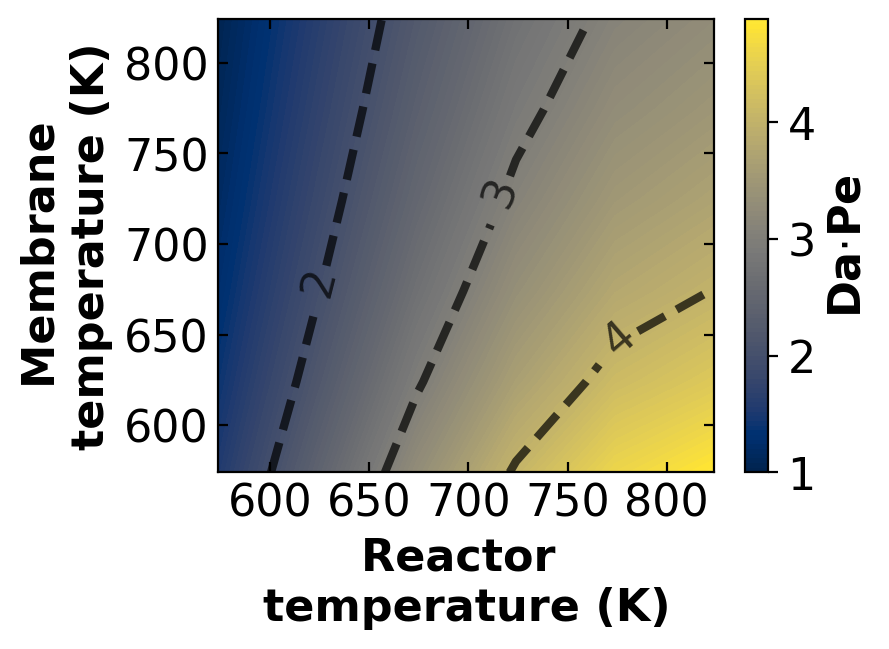

In [17]:
# plot DaPe
if DaPe_contours:
    plt.figure(figsize=(4,3),dpi=200)
    
    levels = 100

    # Make contour plot
    cp = plt.contourf(reactor_mesh, membrane_mesh, DaPe_mesh, cmap=cm.cividis, levels=levels)


    # plot color bar
    cbar = plt.colorbar(cp, ticks=np.arange(1,6,1), format='%d') # ticks=np.arange(60,85,5), format='%d'

    # plot title on color bar
    cbar.ax.set_ylabel('Da$\cdot$Pe',fontsize=16,fontweight='bold')


    # set font size in color bar
    cbar.ax.tick_params(labelsize=16)

    # plot equipotential line
    cp2 = plt.contour(cp, levels=np.arange(1,6,1), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    plt.clabel(cp2, fmt='%2.0f', colors='k', fontsize=16) 

    # define tick size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tick_params(direction="in",top=True, right=True)

    # plot titile and x,y label
    plt.xlabel('Reactor \ntemperature (K)', fontsize=16, fontweight='bold')
    plt.ylabel('Membrane \ntemperature (K)', fontsize=16, fontweight='bold')


    # save figure (important for publications)
    if save_fig:
        plt.savefig('output/temperature_effects_dape{}.png'.format(case),bbox_inches='tight')
        plt.savefig('output/temperature_effects_dape{}.pdf'.format(case),bbox_inches='tight')
    plt.show()

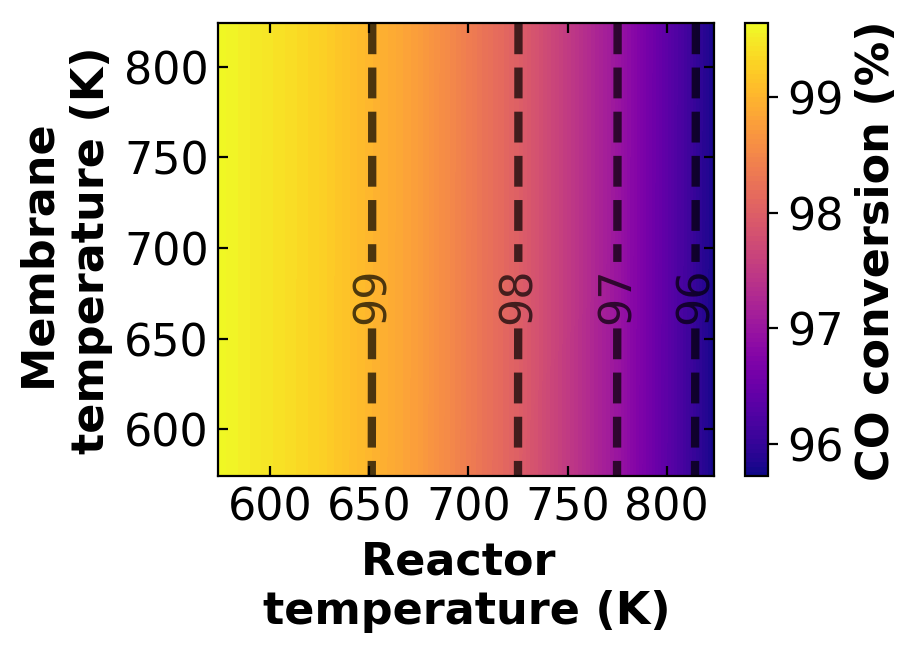

In [18]:
# plot conversion
if DaPe_contours:
    plt.figure(figsize=(4,3),dpi=200)

    # Make contour plot
    cp = plt.contourf(reactor_mesh, membrane_mesh, conversion_mesh, cmap=cm.plasma, levels=100)


    # plot color bar
    cbar = plt.colorbar(cp, ticks=np.arange(96,101,1), format='%d') # ticks=np.arange(60,85,5), format='%d'

    # plot title on color bar
    cbar.ax.set_ylabel('CO conversion (%)',fontsize=16,fontweight='bold')


    # set font size in color bar
    cbar.ax.tick_params(labelsize=16)

    # plot equipotential line
    cp2 = plt.contour(cp, levels=np.arange(96,101,1), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    plt.clabel(cp2, fmt='%2.0f', colors='k', fontsize=16) 

    # define tick size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tick_params(direction="in",top=True, right=True)

    # plot titile and x,y label
    plt.xlabel('Reactor \ntemperature (K)', fontsize=16, fontweight='bold')
    plt.ylabel('Membrane \ntemperature (K)', fontsize=16, fontweight='bold')


    # save figure (important for publications)
    if save_fig:
        plt.savefig('output/temperature_effects_conversion{}.png'.format(case),bbox_inches='tight')
        plt.savefig('output/temperature_effects_conversion{}.pdf'.format(case),bbox_inches='tight')
    plt.show()

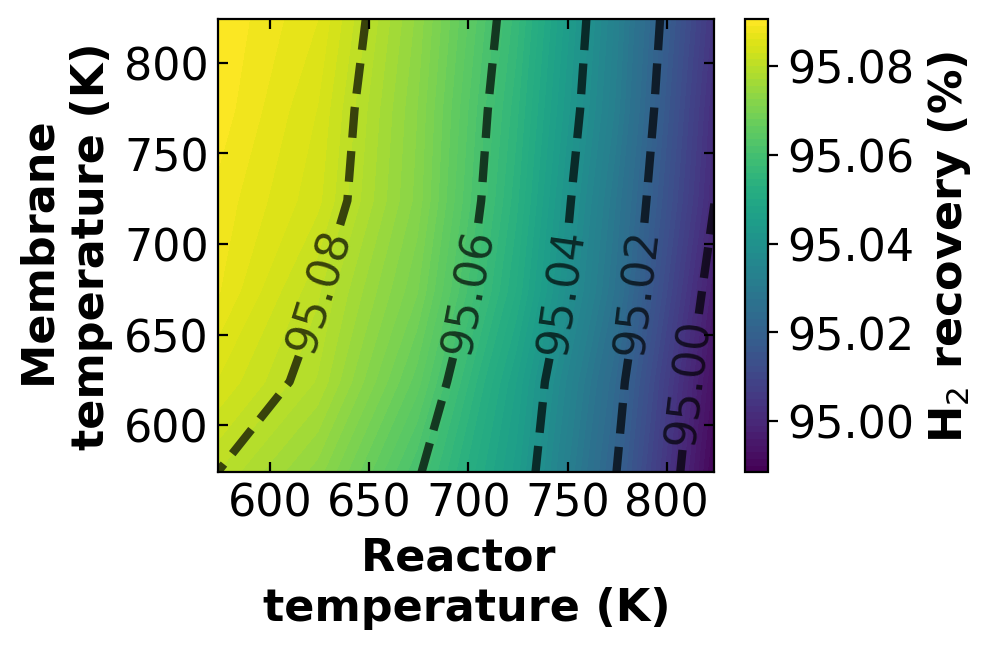

In [19]:
# plot H2 recovery
if DaPe_contours:
    plt.figure(figsize=(4,3),dpi=200)

    # Make contour plot
    cp = plt.contourf(reactor_mesh, membrane_mesh, recovery_mesh, cmap=cm.viridis, levels=100)


    # plot color bar
    cbar = plt.colorbar(cp, ticks=np.arange(95.00,95.10,0.02), format='%.2f') # ticks=np.arange(60,85,5), format='%d'

    # plot title on color bar
    cbar.ax.set_ylabel('H$_2$ recovery (%)',fontsize=16,fontweight='bold')


    # set font size in color bar
    cbar.ax.tick_params(labelsize=16)

    # plot equipotential line
    cp2 = plt.contour(cp, levels=np.arange(95.00,95.10,0.02), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    plt.clabel(cp2, fmt='%.2f', colors='k', fontsize=16) 

    # define tick size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tick_params(direction="in",top=True, right=True)

    # plot titile and x,y label
    plt.xlabel('Reactor \ntemperature (K)', fontsize=16, fontweight='bold')
    plt.ylabel('Membrane \ntemperature (K)', fontsize=16, fontweight='bold')

    # save figure (important for publications)
    if save_fig:
        plt.savefig('output/temperature_effects_recovery{}.png'.format(case),bbox_inches='tight')
        plt.savefig('output/temperature_effects_recovery{}.pdf'.format(case),bbox_inches='tight')
    plt.show()

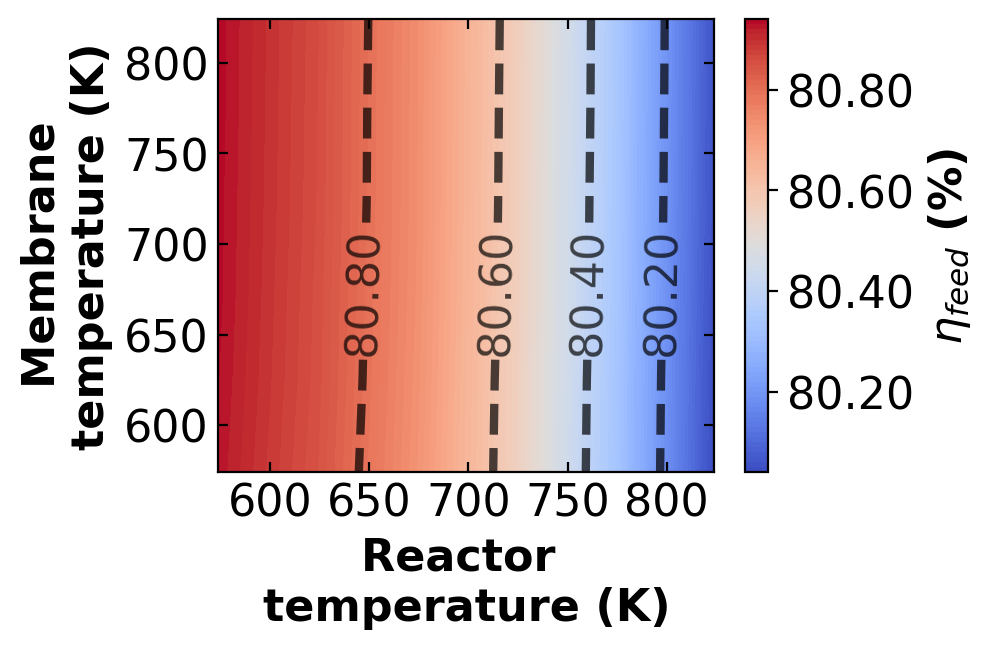

In [20]:
# plot feed utilization efficiency
if DaPe_contours:
    plt.figure(figsize=(4,3),dpi=200)

    # Make contour plot
    cp = plt.contourf(reactor_mesh, membrane_mesh, utilization_mesh, cmap=cm.coolwarm, levels=100)


    # plot color bar
    cbar = plt.colorbar(cp, ticks=np.arange(80.00,81.20,0.20), format='%.2f') # ticks=np.arange(60,85,5), format='%d'

    # plot title on color bar
    cbar.ax.set_ylabel('$\eta_{feed}$ (%)',fontsize=16,fontweight='bold')


    # set font size in color bar
    cbar.ax.tick_params(labelsize=16)

    # plot equipotential line
    cp2 = plt.contour(cp, levels=np.arange(80.00,81.20,0.20), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    plt.clabel(cp2, fmt='%.2f', colors='k', fontsize=16) 

    # define tick size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tick_params(direction="in",top=True, right=True)

    # plot titile and x,y label
    plt.xlabel('Reactor \ntemperature (K)', fontsize=16, fontweight='bold')
    plt.ylabel('Membrane \ntemperature (K)', fontsize=16, fontweight='bold')


    # save figure (important for publications)
    if save_fig:
        plt.savefig('output/temperature_effects_utilization{}.png'.format(case),bbox_inches='tight')
        plt.savefig('output/temperature_effects_utilization{}.pdf'.format(case),bbox_inches='tight')
    plt.show()

In [21]:
print('done')

done
